In [61]:
""" Develop a predictive model using machine learning to analyze customer behavior and provide actionable insights for enhancing user engagement in an e-commerce platform.
Description: The goal of this assignment is to design and implement a machine learning solution capable of analyzing user data, such as browsing history, purchase records,
and click behavior, to predict customer preferences and suggest personalized recommendations. Key aspects of the task include: Data cleaning and preprocessing of raw customer data.
Feature engineering to extract meaningful patterns. Developing a machine learning model (e.g., classification or regression) for customer behavior prediction. 
Evaluation of the models performance using appropriate metrics. Creating a report or dashboard to present findings and insights. 
This project will enhance problem-solving, coding, and analytical skills while providing practical experience in real-world machine learning applications."""

' Develop a predictive model using machine learning to analyze customer behavior and provide actionable insights for enhancing user engagement in an e-commerce platform.\nDescription: The goal of this assignment is to design and implement a machine learning solution capable of analyzing user data, such as browsing history, purchase records,\nand click behavior, to predict customer preferences and suggest personalized recommendations. Key aspects of the task include: Data cleaning and preprocessing of raw customer data.\nFeature engineering to extract meaningful patterns. Developing a machine learning model (e.g., classification or regression) for customer behavior prediction. \nEvaluation of the models performance using appropriate metrics. Creating a report or dashboard to present findings and insights. \nThis project will enhance problem-solving, coding, and analytical skills while providing practical experience in real-world machine learning applications.'

In [63]:
import pandas as pd

In [65]:
#loading a dataset
event=pd.read_csv("events.csv")
print(event.head())
print(event.info())
print(event.duplicated().sum())
print(event["event"].value_counts())
print(len(event))

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None
460
event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64
2756101


In [67]:
# convert timestamps
event["timestamp"]=pd.to_datetime(event["timestamp"],unit="ms")
event.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [69]:
#drop duplicates
event=event.drop_duplicates()

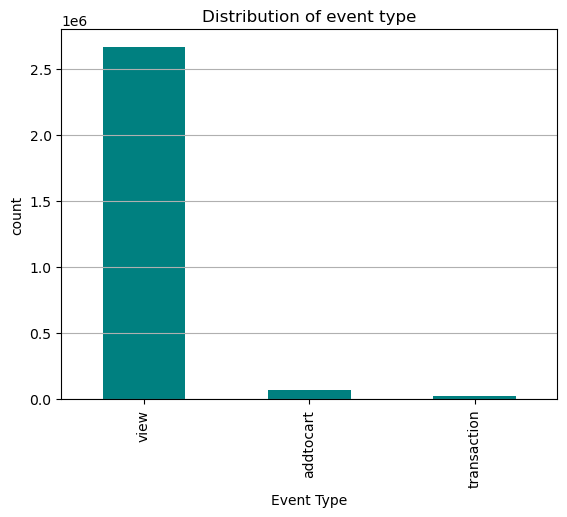

In [71]:
import matplotlib.pyplot as plt

event["event"].value_counts().plot(kind="bar",color="teal")
plt.title("Distribution of event type")
plt.xlabel("Event Type")
plt.ylabel("count")
plt.grid(axis="y")
plt.show()

In [73]:
#this shows how rare the purchases are

In [75]:
#lets filter foe users who have made the transactions
buyers=event[event["event"] == "transaction"]["visitorid"].unique()
events_filtered=event[event["visitorid"].isin(buyers)]

print("original rows:",len(event))
print("filtered rows (only buyers):",len(events_filtered))
print("Unique users in filtered data:",events_filtered["visitorid"].nunique())

original rows: 2755641
filtered rows (only buyers): 230606
Unique users in filtered data: 11719


In [77]:
import numpy as np

# Step 2: Sort by visitor and timestamp
event = event.sort_values(by=['visitorid', 'timestamp'])

# Step 3: Compute time difference between current and previous event per user
event['prev_time'] = event.groupby('visitorid')['timestamp'].shift(1)
event['time_diff'] = (event['timestamp'] - event['prev_time']).dt.total_seconds()

# Step 4: Flag where a new session starts (more than 30 mins or first event)
event['new_session'] = (event['time_diff'] > 1800) | (event['time_diff'].isna())

# Step 5: Assign session IDs by cumulatively summing the new_session flag per user
event['session_id'] = event.groupby('visitorid')['new_session'].cumsum()

# Optional: Create a globally unique session ID for each session
event['full_session_id'] = event['visitorid'].astype(str) + '_' + event['session_id'].astype(str)

print("Total sessions created:", event['full_session_id'].nunique())
print("Sample sessions per user:")
print(event.groupby('visitorid')['full_session_id'].nunique().head())


Total sessions created: 1761675
Sample sessions per user:
visitorid
0    1
1    1
2    1
3    1
4    1
Name: full_session_id, dtype: int64


In [79]:
# calculate session start and end time how long the session lasted
# Group by session to get session start and end time
session_times = event.groupby('full_session_id')['timestamp'].agg(['min', 'max']).reset_index()
session_times.columns = ['full_session_id', 'session_start', 'session_end']

# Calculate duration in seconds
session_times['session_duration'] = (session_times['session_end'] - session_times['session_start']).dt.total_seconds()


In [81]:
#Count views Add-to-carts ,transactions per session as in behaviour
# Count each event type per session
event_counts = event.pivot_table(index='full_session_id',
                                  columns='event',
                                  aggfunc='size',
                                  fill_value=0).reset_index()

# Rename columns for clarity
event_counts.columns.name = None
event_counts = event_counts.rename(columns={
    'view': 'num_views',
    'addtocart': 'num_addtocarts',
    'transaction': 'num_transactions'
})


In [83]:
#number of unique items per session
unique_items = event.groupby('full_session_id')['itemid'].nunique().reset_index()
unique_items.columns = ['full_session_id', 'unique_items']


In [85]:
event_total = event.groupby('full_session_id').size().reset_index(name='event_count')
#total event count per session

In [87]:
#Hour of Day
# Merge session start time
session_features = session_times[['full_session_id', 'session_start']].copy()
session_features['hour_of_day'] = session_features['session_start'].dt.hour


In [89]:
#Add visitor id back to Session
visitor_ids = event.groupby('full_session_id')['visitorid'].first().reset_index()


In [91]:
#label :Was there a purchase in session made mostly can be targeted variable
# If num_transactions > 0 → purchase made
event_counts['purchase_made'] = (event_counts['num_transactions'] > 0).astype(int)


In [93]:
#merge all features together
# Merge all session-level features
session_df = session_features.merge(visitor_ids, on='full_session_id') \
                             .merge(session_times[['full_session_id', 'session_duration']], on='full_session_id') \
                             .merge(event_counts, on='full_session_id') \
                             .merge(unique_items, on='full_session_id') \
                             .merge(event_total, on='full_session_id')


In [95]:
print(session_df.head())
print(session_df["purchase_made"].value_counts())

  full_session_id           session_start  hour_of_day  visitorid  \
0             0_1 2015-09-11 20:49:49.439           20          0   
1       1000000_1 2015-06-05 18:16:10.629           18    1000000   
2       1000001_1 2015-07-07 18:12:14.953           18    1000001   
3       1000001_2 2015-07-24 20:18:15.303           20    1000001   
4       1000001_3 2015-07-29 20:38:29.170           20    1000001   

   session_duration  num_addtocarts  num_transactions  num_views  \
0           327.736               0                 0          3   
1             0.000               0                 0          1   
2             0.000               0                 0          1   
3          1061.726               0                 0          3   
4             0.000               0                 0          1   

   purchase_made  unique_items  event_count  
0              0             3            3  
1              0             1            1  
2              0             1        

In [97]:
#spliting dataset into features and target
# Features to use (drop identifiers and target)
X = session_df.drop(columns=['full_session_id', 'visitorid', 'purchase_made', 'session_start','num_transactions'])

# Target variable
y = session_df['purchase_made']


In [99]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [101]:
#teature scaling for better performance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [103]:
#Handling imbalance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)


In [105]:
model.fit(X_train, y_train)
#train the model

RandomForestClassifier(class_weight='balanced', random_state=42)

In [107]:
#make predections
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC


In [109]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
#lets evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    349476
           1       0.98      0.93      0.95      2859

    accuracy                           1.00    352335
   macro avg       0.99      0.96      0.98    352335
weighted avg       1.00      1.00      1.00    352335


Confusion Matrix:
[[349425     51]
 [   201   2658]]

ROC-AUC Score: 0.9994


In [ ]:
''' True Positives (TP): 2658 buyers correctly predicted

 False Negatives (FN): 201 buyers missed

 True Negatives (TN): 349425 non-buyers correctly predicted

 False Positives (FP): 51 non-buyers misclassified as buyers 
 Metrics
Metric	Score	Meaning
Precision (Class 1)	0.98	98% of predicted buyers are actually buyers 
Recall (Class 1)	0.93	93% of all actual buyers are correctly identified 
F1-Score (Class 1)	0.95	Strong balance of precision and recall 
ROC-AUC	0.9994	Outstanding class separability '''

In [59]:
print(X_train.columns)

Index(['hour_of_day', 'session_duration', 'num_addtocarts', 'num_transactions',
       'num_views', 'unique_items', 'event_count'],
      dtype='object')


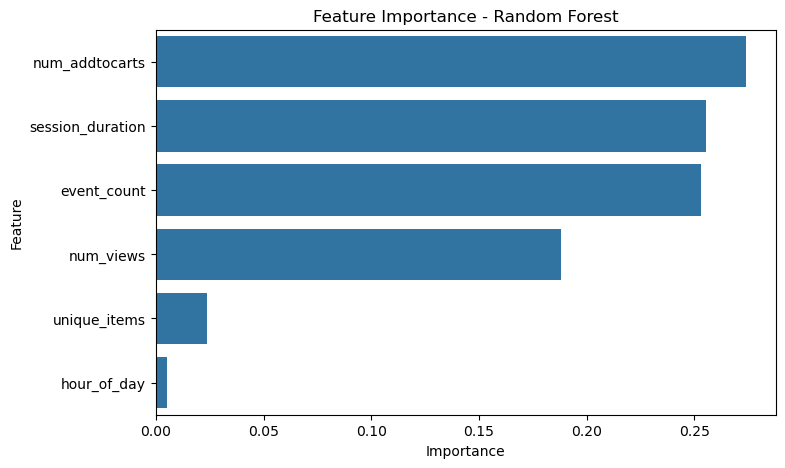

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()


In [113]:
predicted_df = X_test.copy()
predicted_df['actual'] = y_test.values
predicted_df['predicted'] = y_pred
predicted_df['probability'] = y_proba
predicted_df.to_csv("session_predictions.csv", index=False)


In [115]:
importance_df.to_csv("feature_importance.csv", index=False)
